# Transportation Data Analyst Take-Home Assignment

##### Submitted by Ryan Virgin

When a Citymapper team holiday goes tragically wrong, Emily and Gabriel find
themselves stranded on a tropical island. They decide to spend their time
waiting for rescue by answering the universe's hardest transit questions.
With help from some friendly locals, Emily and Gabriel build some things:

1. Emily builds The Waterfall Railway: a little train line running along the
northern end of the island to Island City.
2. Gabriel builds Banana Buses, which connect various parts of the island to
the beach.
3. Together, they build a navigation app called IslandMapper, to help
themselves and their new island friends get around.

**Below I will evaluate the provided data and provide my own responses to the provided issues with the transit system described above**

#### Library Imports

In [3]:
import numpy as np
import pandas as pd
import gtfs_kit as gk

import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import Point, LineString
from matplotlib.lines import Line2D
from IPython.display import Image

#### Data Import

In [4]:
path = 'Data/Data/'

In [5]:
feed = gk.read_feed(path, dist_units='mi')

In [6]:
feed.validate()

,type,message,table,rows
0,warning,Feed expired,calendar,[]


## What do the data look like?

In [7]:
feed.stops

,stop_id,stop_name,stop_lat,stop_lon
0,Stop_IslandCity,Island City Central Station,49.712802,-179.280571
1,Stop_BeachNorth,The Beach (North) Rail Station,49.493027,-178.975434
2,Stop_HauntedJungle,The Haunted Jungle,49.462797,179.866938
3,Stop_BambooCross,Bamboo Crossroads,49.433159,-179.115743
4,Stop_BeachSouth,The Beach (South) Bus Station,49.403503,-178.966984


In [8]:
feed.stop_times.head(5)

,trip_id,arrival_time,departure_time,stop_id,stop_sequence
0,Waterfall_0001,14:00:00,14:00:00,Stop_BeachNorth,1
1,Waterfall_0001,14:15:00,14:15:00,Stop_IslandCity,2
2,Waterfall_0003,14:15:00,14:15:00,Stop_BeachNorth,1
3,Waterfall_0003,14:30:00,14:30:00,Stop_IslandCity,2
4,Waterfall_0005,14:30:00,14:30:00,Stop_BeachNorth,1


In [9]:
feed.agency

,agency_id,agency_name,agency_url,agency_timezone
0,WaterfallRailway,The Waterfall Railway,https://citymapper.com/,America/Adak
1,BananaBuses,Banana Bus Company,https://citymapper.com/,America/Adak


In [10]:
feed.calendar

,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,Weekdays,1,1,1,1,1,0,0,20170101,20220101
1,Weekends,0,0,0,0,0,1,1,20170101,20220101


In [11]:
feed.frequencies

,trip_id,start_time,end_time,headway_secs
0,Banana_Ban1_1001,14:05:00,14:35:00,600
1,Banana_Ban1_1002,14:00:00,14:30:00,600
2,Banana_Ban2_1001,14:05:00,14:35:00,600
3,Banana_Ban2_1002,14:00:00,14:30:00,600


In [12]:
feed.routes

,route_id,agency_id,route_short_name,route_long_name,route_type
0,Waterfall1,WaterfallRailway,WF1,The Beach <-> Island City,2
1,BananaBus1,BananaBuses,Ban1,The Beach <-> Island City,3
2,BananaBus2,BananaBuses,Ban2,The Beach <-> The Haunted Jungle,3


In [13]:
feed.trips.head()

,route_id,service_id,trip_id,trip_headsign
0,Waterfall1,Weekdays,Waterfall_0001,Island City
1,Waterfall1,Weekdays,Waterfall_0002,The Beach (North)
2,Waterfall1,Weekdays,Waterfall_0003,Island City
3,Waterfall1,Weekdays,Waterfall_0004,The Beach (North)
4,Waterfall1,Weekdays,Waterfall_0005,Island City


## Mapping the Data

I want to get a clear idea for what the Island looks like and how the stops and routes look spatially. To do this, I'll map it out and see if that helps me build a clearer picture (clearer that the provided drawing)

The dataframes 'stop_times' and 'trips' share the feature 'trip_id'. Let's merge them

In [14]:
stop_trip_merge = pd.merge(feed.stop_times, feed.trips, on ='trip_id')
stop_trip_merge.head(3)

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,route_id,service_id,trip_headsign
0,Waterfall_0001,14:00:00,14:00:00,Stop_BeachNorth,1,Waterfall1,Weekdays,Island City
1,Waterfall_0001,14:15:00,14:15:00,Stop_IslandCity,2,Waterfall1,Weekdays,Island City
2,Waterfall_0003,14:15:00,14:15:00,Stop_BeachNorth,1,Waterfall1,Weekdays,Island City


Now we have an idea of which trips correspond to which stops and at which times. I think we can garner more information by merging this onto the routes df.

In [15]:
stop_route_merge = pd.merge(stop_trip_merge, feed.routes, on = 'route_id')
stop_route_merge.head(5)

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,route_id,service_id,trip_headsign,agency_id,route_short_name,route_long_name,route_type
0,Waterfall_0001,14:00:00,14:00:00,Stop_BeachNorth,1,Waterfall1,Weekdays,Island City,WaterfallRailway,WF1,The Beach <-> Island City,2
1,Waterfall_0001,14:15:00,14:15:00,Stop_IslandCity,2,Waterfall1,Weekdays,Island City,WaterfallRailway,WF1,The Beach <-> Island City,2
2,Waterfall_0003,14:15:00,14:15:00,Stop_BeachNorth,1,Waterfall1,Weekdays,Island City,WaterfallRailway,WF1,The Beach <-> Island City,2
3,Waterfall_0003,14:30:00,14:30:00,Stop_IslandCity,2,Waterfall1,Weekdays,Island City,WaterfallRailway,WF1,The Beach <-> Island City,2
4,Waterfall_0005,14:30:00,14:30:00,Stop_BeachNorth,1,Waterfall1,Weekdays,Island City,WaterfallRailway,WF1,The Beach <-> Island City,2


In [16]:
geometry = [Point(xy) for xy in zip(feed.stops.stop_lon, feed.stops.stop_lat)]
stops_gdf = gpd.GeoDataFrame(feed.stops, geometry=geometry)

This adds a geometry feature to the stops df which  we can use to plot the stops. Next, we'll do the same for the routes.

In [17]:
stops_gdf

,stop_id,stop_name,stop_lat,stop_lon,geometry
0,Stop_IslandCity,Island City Central Station,49.712802,-179.280571,POINT (-179.28057 49.71280)
1,Stop_BeachNorth,The Beach (North) Rail Station,49.493027,-178.975434,POINT (-178.97543 49.49303)
2,Stop_HauntedJungle,The Haunted Jungle,49.462797,179.866938,POINT (179.86694 49.46280)
3,Stop_BambooCross,Bamboo Crossroads,49.433159,-179.115743,POINT (-179.11574 49.43316)
4,Stop_BeachSouth,The Beach (South) Bus Station,49.403503,-178.966984,POINT (-178.96698 49.40350)


In [18]:
stops_gdf.set_index('stop_id', inplace=True)

In [19]:
all_routes_sorted = stop_route_merge.sort_values(by=['trip_id', 'stop_sequence'])
all_routes_sorted.head(5)

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,route_id,service_id,trip_headsign,agency_id,route_short_name,route_long_name,route_type
12,Banana_Ban1_1001,00:00:00,00:00:00,Stop_BeachSouth,1,BananaBus1,Weekdays,Westbound,BananaBuses,Ban1,The Beach <-> Island City,3
13,Banana_Ban1_1001,00:05:00,00:07:00,Stop_BambooCross,2,BananaBus1,Weekdays,Westbound,BananaBuses,Ban1,The Beach <-> Island City,3
14,Banana_Ban1_1001,00:15:00,00:15:00,Stop_IslandCity,3,BananaBus1,Weekdays,Westbound,BananaBuses,Ban1,The Beach <-> Island City,3
15,Banana_Ban1_1002,00:00:00,00:00:00,Stop_IslandCity,1,BananaBus1,Weekdays,Eastbound,BananaBuses,Ban1,The Beach <-> Island City,3
16,Banana_Ban1_1002,00:08:00,00:10:00,Stop_BambooCross,2,BananaBus1,Weekdays,Eastbound,BananaBuses,Ban1,The Beach <-> Island City,3


In [20]:
lines = stop_route_merge.groupby('trip_id').apply(lambda group: LineString(stops_gdf.loc[group.stop_id].geometry.tolist()))

In [21]:
lines_gdf = gpd.GeoDataFrame(geometry=lines)
lines_gdf

,geometry
trip_id,
Banana_Ban1_1001,"LINESTRING (-178.96698 49.40350, -179.11574 49..."
Banana_Ban1_1002,"LINESTRING (-179.28057 49.71280, -179.11574 49..."
Banana_Ban2_1001,"LINESTRING (-178.96698 49.40350, -179.11574 49..."
Banana_Ban2_1002,"LINESTRING (179.86694 49.46280, -179.11574 49...."
Waterfall_0001,"LINESTRING (-178.97543 49.49303, -179.28057 49..."
Waterfall_0002,"LINESTRING (-179.28057 49.71280, -178.97543 49..."
Waterfall_0003,"LINESTRING (-178.97543 49.49303, -179.28057 49..."
Waterfall_0004,"LINESTRING (-179.28057 49.71280, -178.97543 49..."
Waterfall_0005,"LINESTRING (-178.97543 49.49303, -179.28057 49..."


In [22]:
stops_gdf.reset_index(inplace=True)

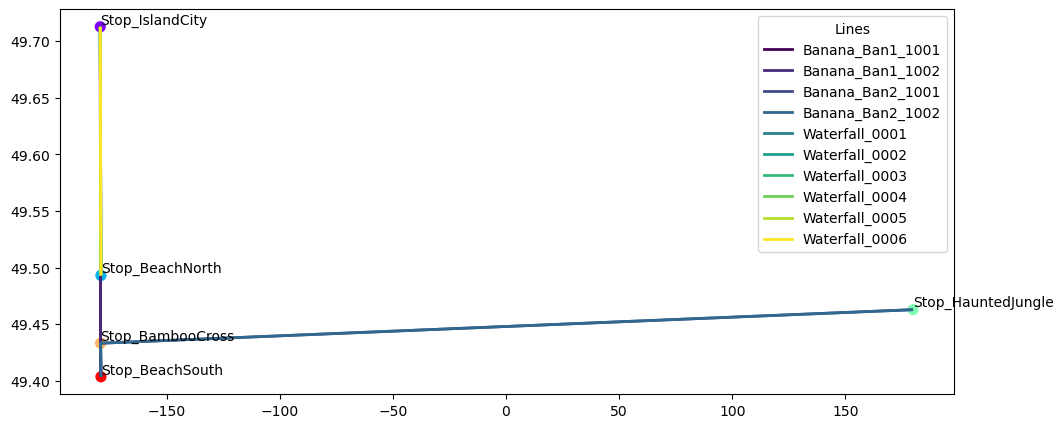

In [23]:
fig, ax = plt.subplots(figsize=(50,5))
ax.set_aspect('equal', 'box')

colors_lines = plt.cm.viridis(np.linspace(0, 1, len(lines_gdf)))

line_labels = []
for counter, (idx, row) in enumerate(lines_gdf.iterrows()):
    line_gdf = gpd.GeoDataFrame(geometry=[row['geometry']])
    line_gdf.plot(ax=ax, color=colors_lines[counter], linewidth=2.0)
    line_labels.append(idx)

line_legend = [Line2D([0], [0], color=color, lw=2) for color in colors_lines]
ax.legend(line_legend, line_labels, title='Lines', loc='upper right')

# color-coding and labeling stops
unique_stops = stops_gdf['stop_id'].unique()
colors_stops = plt.cm.rainbow(np.linspace(0, 1, len(unique_stops)))
stop_colors = {stop: color for stop, color in zip(unique_stops, colors_stops)}
stops_gdf['colors'] = stops_gdf['stop_id'].map(stop_colors)
stops_gdf.plot(ax=ax, color=stops_gdf['colors'], markersize=50)

# labeling stops on the chart
for _, row in stops_gdf.iterrows():
    ax.text(row['geometry'].x, row['geometry'].y, row['stop_id'], fontsize=10, verticalalignment='bottom')

aspect_ratio = 500
ax.set_aspect(aspect_ratio)

plt.show()
fig.savefig('maps/large_map.png')

The Haunted Jungle is very far away.

1 degree of Longitude change is approximately 288,200 feet of spherical distance.
1 degree of Latitude change is approximately 364,000 feet of spherical distance.

For people looking to travel from South Beach to Island city, they'll have to travel about .3 degrees of latitude. This is equivalent to about 109200 feet (~21 miles). However if you're at Bamboo Cross and you want to get to the Haunted Jungle, you better not forget to pack a lunch.

The distance between Bamboo Cross and the Haunted Jungle is 358 degree of longitude (24,716 miles), spanning approximately the entire earth (assuming this is earth).

### Zoomed-in Map

If you'll notice, in the above plot, not all of the routes are visible. This is because of the aspect ratio that I used. While the aspect ratio allowed me to show each stop and line within the frame, it compressed the necessary information into a smaller frame and caused some of the features to overlap. Below is the same plot, but the x axis is clipped at -150 latitude.

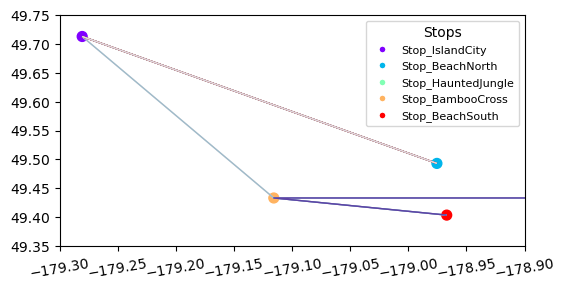

In [24]:
fig, ax = plt.subplots(figsize=(6,3))

# color coding lines
colors_lines = plt.cm.twilight(np.linspace(0, 1, len(lines_gdf)))
line_labels = []
for counter, (idx, row) in enumerate(lines_gdf.iterrows()):
    line_gdf = gpd.GeoDataFrame(geometry=[row['geometry']])
    line_gdf.plot(ax=ax, color=colors_lines[counter], linewidth=1.0)
    line_labels.append(idx)

stop_legend = [Line2D([0], [0], marker='o', color='w', markerfacecolor=stop_colors[stop], markersize=5) 
               for stop in unique_stops]
ax.legend(stop_legend, unique_stops, title='Stops', loc='upper right',fontsize =8)

# color coding/ labeling stops
unique_stops = stops_gdf['stop_id'].unique()
colors_stops = plt.cm.rainbow(np.linspace(0, 1, len(unique_stops)))
stop_colors = {stop: color for stop, color in zip(unique_stops, colors_stops)}
stops_gdf['colors'] = stops_gdf['stop_id'].map(stop_colors)
stops_gdf.plot(ax=ax, color=stops_gdf['colors'], markersize=50)

# for _, row in stops_gdf.iterrows():
#     ax.text(row['geometry'].x, row['geometry'].y, row['stop_id'], fontsize=10, verticalalignment='bottom',transform=ax.transAxes)

# aspect_ratio = 500
ax.set_aspect('auto')

ax.set_xlim([-179.3, -178.9])
ax.set_ylim([49.35, 49.75])
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=10)

plt.show()
fig.savefig('maps/zoomed_map.png')

This shows how the stops are arranged in better detail than the first image. Now we can see that the trip from beach north to bamboo cross or to beach south is more difficult than it first seemed.

Now that we have a better sense of the layout of everything, let's look at the problems.

## Problems

**1. The Waterfall Railway is the suggested route for getting from The Beach to
Island City. But during Monsoon season, many people living on the southern
end of the beach say they prefer Banana Buses. By looking at the data, can
you suggest why this might be?**


Monsoon means rain. A lot of it and, potentially, unexpectedly. If people are opting to take the lesser of two routes, they must be doing so for good reason. If I had to choose between getting to my destination on time and wet or 10 minutes late and dry, I'm choosing the latter.

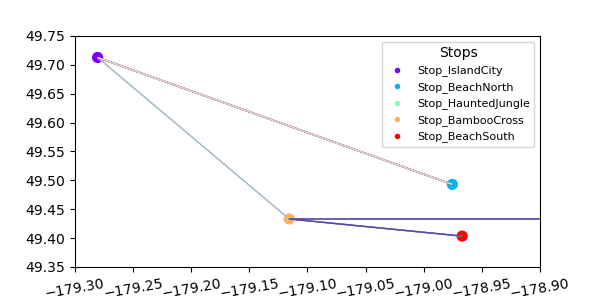

In [36]:
Image(filename='maps/zoomed_map.png')

From the map we discussed above, we can see that the journey from the southern end of the beach to Island City (purple) is more complicated than if you were coming from the north end of the beach (blue). People heading to the city from the south end of the beach (red) are served by only the Banana buses which originate and terminate at one station (Beach south stop).

During monsoon season, the walk from the south end of the beach to the north end to catch the direct waterfall line into the city might be too long for most people. Additionally, the Banana buses serve the Beach South stop more frequently.

Let's check to see how often both transit lines operate at the southern most stop on the island and verify if the transit frequency at the stop could be a potential cause for this behavior

In [32]:
stop_id = feed.stops['stop_id'][4]
stop_id

'Stop_BeachSouth'

In the code provided in the mapping stage of this analysis, we created a variable called 'stop_route_merge', which is a merged version of stop times and routes. Let's use this df to look at the time between stops at the BeachSouth Stop.

This dataframe is long, so first we'll have to specify only the south stop.

In [33]:
freq_check = stop_route_merge[stop_route_merge['stop_id'] == stop_id]
freq_check[['trip_id','trip_headsign','arrival_time']]

,trip_id,trip_headsign,arrival_time
12,Banana_Ban1_1001,Westbound,00:00:00
17,Banana_Ban1_1002,Eastbound,00:15:00
18,Banana_Ban2_1001,Westbound,00:00:00
23,Banana_Ban2_1002,Eastbound,00:20:00


I'm interpretting this data to mean that there's a bus that arrives at BeachSouth heading westbound every 15 minutes

In [34]:
timetable = stop_route_merge[(stop_route_merge['trip_headsign'] == 'Westbound') | (stop_route_merge['trip_headsign'] =='Island City') | (stop_route_merge['trip_headsign'] =='Island City') ]
freq_df = timetable.pivot_table(index="stop_id", columns="route_id", values="departure_time", aggfunc=list).reset_index()

In [35]:
freq_df

route_id,stop_id,BananaBus1,BananaBus2,Waterfall1
0,Stop_BambooCross,[00:07:00],[00:07:00],NaN
1,Stop_BeachNorth,NaN,NaN,"[14:00:00, 14:15:00, 14:30:00]"
2,Stop_BeachSouth,[00:00:00],[00:00:00],NaN
3,Stop_HauntedJungle,NaN,[00:20:00],NaN
4,Stop_IslandCity,[00:15:00],NaN,"[14:15:00, 14:30:00, 14:45:00]"


This shows us that the Waterfall line from BeachNorth to the city arrives every 15 minutes and the Beach South stop is served at 0:00 and 0:20. Unless I'm misinterpretting this data, as the stated headway for each line in the frequency data is 600s (10 minutes). In this case, the frequency would remain equal between the two stops.

**Answer:**  It appears that people on the south end of the beach prefer the Banana bus over the more direct Waterfall line because it is closer and requires less walking in the rain. The closest stop from the Beach South station that provides a direct route to the city is the Beach North stop, which is ~.1 degrees of latitude away (6.9 miles). Much too far to walk and probably not very comfortable to bike to in the rain.

**2.  Many people catching Banana Buses from the beach find themselves
accidentally catching the wrong one and ending up in the Haunted Jungle
instead. What could be improved in the data to help prevent this, and what
specifically would you change?**


As we see in the timetable dataframe I created previously:

In [181]:
timetable = stop_route_merge[(stop_route_merge['route_long_name'] == 'The Beach <-> Island City')]
freq_df = timetable.pivot_table(index="stop_id", columns="route_id", values="departure_time", aggfunc=list).reset_index()

In [182]:
freq_df

route_id,stop_id,BananaBus1,Waterfall1
0,Stop_BambooCross,"[00:07:00, 00:10:00]",NaN
1,Stop_BeachNorth,NaN,"[14:00:00, 14:15:00, 14:30:00, 14:20:00, 14:35..."
2,Stop_BeachSouth,"[00:00:00, 00:15:00]",NaN
3,Stop_IslandCity,"[00:15:00, 00:00:00]","[14:15:00, 14:30:00, 14:45:00, 14:05:00, 14:20..."


Shows the arrival times for all routes at each stop. This uses the route_long_name 'The Beach <-> Island City' which indicates that the route is headed from X to island city.

In [40]:
all_routes_sorted[(all_routes_sorted['route_long_name'] == 'The Beach <-> The Haunted Jungle') |(all_routes_sorted['trip_headsign'] == 'Westbound') & (all_routes_sorted['trip_headsign'] == 'Eastbound')]

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,route_id,service_id,trip_headsign,agency_id,route_short_name,route_long_name,route_type
18,Banana_Ban2_1001,00:00:00,00:00:00,Stop_BeachSouth,1,BananaBus2,Weekdays,Westbound,BananaBuses,Ban2,The Beach <-> The Haunted Jungle,3
19,Banana_Ban2_1001,00:05:00,00:07:00,Stop_BambooCross,2,BananaBus2,Weekdays,Westbound,BananaBuses,Ban2,The Beach <-> The Haunted Jungle,3
20,Banana_Ban2_1001,00:20:00,00:20:00,Stop_HauntedJungle,3,BananaBus2,Weekdays,Westbound,BananaBuses,Ban2,The Beach <-> The Haunted Jungle,3
21,Banana_Ban2_1002,00:00:00,00:00:00,Stop_HauntedJungle,1,BananaBus2,Weekdays,Eastbound,BananaBuses,Ban2,The Beach <-> The Haunted Jungle,3
22,Banana_Ban2_1002,00:13:00,00:15:00,Stop_BambooCross,2,BananaBus2,Weekdays,Eastbound,BananaBuses,Ban2,The Beach <-> The Haunted Jungle,3
23,Banana_Ban2_1002,00:20:00,00:20:00,Stop_BeachSouth,3,BananaBus2,Weekdays,Eastbound,BananaBuses,Ban2,The Beach <-> The Haunted Jungle,3


If we look at the route headed to Island City OR Haunted Jungle, we see:

In [187]:
timetable = stop_route_merge[(stop_route_merge['route_long_name'] == 'The Beach <-> Island City') | (stop_route_merge['route_long_name'] == 'The Beach <-> The Haunted Jungle')]
freq_df = timetable.pivot_table(index="stop_id", columns="route_id", values="departure_time", aggfunc=list).reset_index()

In [188]:
freq_df

route_id,stop_id,BananaBus1,BananaBus2,Waterfall1
0,Stop_BambooCross,"[00:07:00, 00:10:00]","[00:07:00, 00:15:00]",NaN
1,Stop_BeachNorth,NaN,NaN,"[14:00:00, 14:15:00, 14:30:00, 14:20:00, 14:35..."
2,Stop_BeachSouth,"[00:00:00, 00:15:00]","[00:00:00, 00:20:00]",NaN
3,Stop_HauntedJungle,NaN,"[00:20:00, 00:00:00]",NaN
4,Stop_IslandCity,"[00:15:00, 00:00:00]",NaN,"[14:15:00, 14:30:00, 14:45:00, 14:05:00, 14:20..."


We see that there are two buses that arrive at Beach South at 0:00. One heading to the city and one heading to the Jungle. Buses are marked with the headsign 'Eastbound' or 'Westbound'. Additionally, if someone misses the 0:15 bus citybound, they may also try to mistakenly catch the 00:20 bus by mistake and end up in the Haunted Jungle.

**Answer:**  It's understandable how someone might accidentally catch the wrong bus and end up in the Haunted Jungle, as there are two buses that arrive at the station at the same time.

To improve this situation, it would be wise to offset the arrival times for both buses and to adjust the headsign wording to make it more clear which destination a passenger would be headed to. It wouldn't hurt to discuss the timing of the additional 00:20 arrival, as offsetting the arrival time for that bus to the Jungle may be advantageous.

**3.  The GTFS file specifies Waterfall Railway and Banana Bus schedules in
different ways. If you were standing in the middle of The Beach at 14:23,
which would you be more likely to see first: a Waterfall Train or a Banana
Bus? Explain why you think this, and why you may be wrong.**

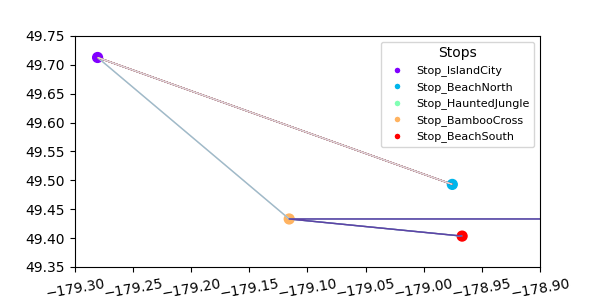

In [191]:
Image(filename='maps/zoomed_map.png')

From the middle of the beach, we can assume we'd be somewhere in near the purple line in the above map. From the frequency table shown below, we can see that there's a train departing Beach North at 14:20 and also at 14:30.

In [194]:
freq_df = stop_route_merge.pivot_table(index="stop_id", columns="route_id", values="departure_time", aggfunc=list).reset_index()
freq_df

route_id,stop_id,BananaBus1,BananaBus2,Waterfall1
0,Stop_BambooCross,"[00:07:00, 00:10:00]","[00:07:00, 00:15:00]",NaN
1,Stop_BeachNorth,NaN,NaN,"[14:00:00, 14:15:00, 14:30:00, 14:20:00, 14:35..."
2,Stop_BeachSouth,"[00:00:00, 00:15:00]","[00:00:00, 00:20:00]",NaN
3,Stop_HauntedJungle,NaN,"[00:20:00, 00:00:00]",NaN
4,Stop_IslandCity,"[00:15:00, 00:00:00]",NaN,"[14:15:00, 14:30:00, 14:45:00, 14:05:00, 14:20..."


**Answer:** Because of this, it's reasonable to assume that you'd see a Waterfall train first (either arriving or departing). This is because the Waterfall line specifically states an arrival/departure time of 14:20.  But, as noted in the problem statement, the timing provided in the GTFS data is different for both lines. The Waterfall Train explicitely states a time of arrival, whereas the bus appears to be providing a frequency of arrivals.

If we're assuming that the bus line is providing frequency of arrival, based on the timetable shown above the train and bus should be departing the respective stations at the same time (14:20 and 00:20/train).

**4. A number of bug reports have come in about the IslandMapper app
mysteriously crashing when people enter The Haunted Jungle. Except for
ghosts, can you suggest what may be causing the crash by looking at the
data and seeing if there's anything special about The Haunted Jungle?**

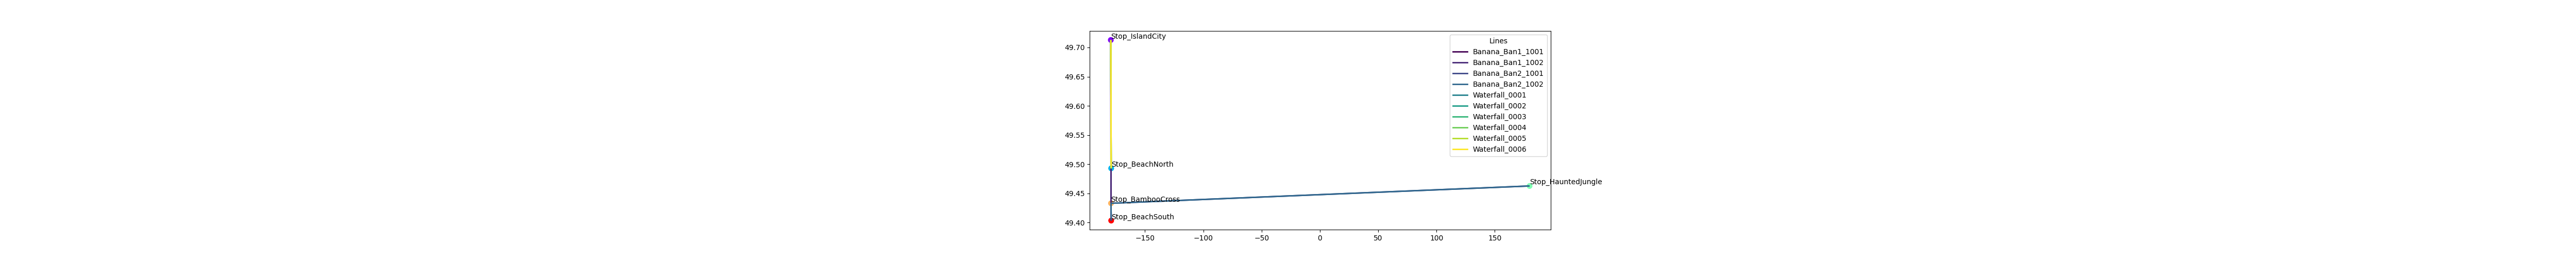

In [196]:
Image(filename='maps/large_map.png')

**Answer:** There may be other reasons for this, but the first thing I notice about the Haunted Jungle is how much further that stop is from the other stops. Specifically, the longitude of the stop is 179.9 which would cross the abs(longitude) of the other stops (~-178). It's possible that the app could get confused as the bus crosses the absolute value of the longitude value it associates with the other stops. 

There's many assumptions being made regarding the characteristics of this island, but if the train is travelling 360 of longitude, then the time zones would also likely shift as a passenger was riding on the bus. This could also present a potential error within the app that might arise as the bus enters the Haunted Jungle.

Based on the merged dfs created previously (below), I don't see other explanations for this behavior.

In [41]:
stop_route_merge[stop_route_merge['stop_id']=='Stop_HauntedJungle']

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,route_id,service_id,trip_headsign,agency_id,route_short_name,route_long_name,route_type
20,Banana_Ban2_1001,00:20:00,00:20:00,Stop_HauntedJungle,3,BananaBus2,Weekdays,Westbound,BananaBuses,Ban2,The Beach <-> The Haunted Jungle,3
21,Banana_Ban2_1002,00:00:00,00:00:00,Stop_HauntedJungle,1,BananaBus2,Weekdays,Eastbound,BananaBuses,Ban2,The Beach <-> The Haunted Jungle,3
